The tutorials use PyTorch. You will need to load the following dependencies.

In [1]:
# This specific version of torchvision is needed to download the mnist set
# !pip install torchvision==0.9.1  torch==1.8.0
# !pip install torch==1.7.1 torchvision==0.8.2

In [2]:
import random

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from IPython import display


The code below may be helpful in visualizing PyTorch tensors as images.

In [3]:
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## First tutorial:

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.



In [5]:
# Load the training and test dataset.
mnist_train = datasets.MNIST('/tmp/mnist', train=True, download=True)
mnist_test = datasets.MNIST('/tmp/mnist', train=False, download=True)


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw




Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw




Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw




Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Show a random image and the corresponding target.
img, target = mnist_train[0]
print('Label of image:', mnist_train.classes[target])
img

Label of image: 5 - five


Next, we create a PyTorch dataloader for the MNIST dataset.

In [ ]:
# This ensures the MNIST dataset produces PyTorch tensors.
mnist_train.transform = transforms.ToTensor()
mnist_test.transform = transforms.ToTensor()

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Show a random image and the corresponding target.
img, target = mnist_train[0]
print('Label of image:', mnist_train.classes[target])

Label of image: 5 - five


Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


In [ ]:
class LogisticRegression(nn.Module):
  """Linear logistic regression model."""
  
  def __init__(self, input_size, num_classes):
    super().__init__()
    ###########################################################################
    # TODO: Instantiate the layer here.                                       #
    ###########################################################################
    self.linear = nn.Linear(input_size, num_classes)
    
  def forward(self, x):
    ###########################################################################
    # TODO: Apply the layer to the input.                                     #
    ###########################################################################
    return self.linear(x.view(x.shape[0], -1))


We will use the following generic training loop for a PyTorch model.

In [ ]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device.
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    for epoch in range(num_epochs):
      
      # Loop over data.
      for batch_idx, (data, target) in enumerate(data_loader):
          data = data.to(device)
          target = target.to(device)
        
          # Forward pass.
          output = model(data)
          loss = criterion(output, target)
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # NOTE: It is important to call .item() on the loss before summing.
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
          # Print out progress.
          if batch_idx % 500 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), 
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), ema_loss),
              )

**Question:** For the model you are currently using, is there any difference between using the model in `train` mode or using it in `eval` mode? 

Create an SGD optimizer and us it to train the logistic regressor on the MNIST training data for a few epochs. What loss function do you need to use?

In [ ]:
# Create model, criterion, and optimizer.
model = LogisticRegression(28 * 28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=0.01, params=model.parameters())


# Train the model. If everything is correct, the loss should go below 0.45.
train(model, criterion, train_loader, optimizer, num_epochs=5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290858
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.908567
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.661144
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.563612
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.508760
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.475901
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.450935
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.433335
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.431091
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.411763


Visualize the weights of the trained model. What do you see? Why?

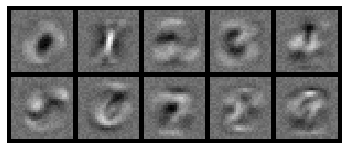

In [ ]:
assert model.linear.weight.shape == (10, 28 * 28)
show(torchvision.utils.make_grid(
    model.linear.weight.view(10, 1, 28, 28),
    normalize=True,
    nrow=5,
))

Use the following function to measure the test accuracy of your trained model.

In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
      
        # Loop over test data.
        for data, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct, 
          len(data_loader.dataset),
          100. * correct / len(data_loader.dataset)),
    )  

In [ ]:
# Accuracy should be around 90%.
test(model, test_loader)

Accuracy: 9004/10000 (90%)



**Question:** To have the logistic regressor output probabilities, they need to be processed through a softmax layer. Implement a softmax layer yourself. What numerical issues may arise in this layer? How can you solve them? Use the testing code to confirm you implemented it correctly.

In [ ]:
F = nn.functional

In [ ]:
def bad_softmax(logits):
  """Computes softmax in a naive manner."""
  probs = logits.exp()
  probs /= probs.sum(-1, keepdim=True)
  return probs

def good_softmax(logits):
  """Computes softmax in a numerically safe manner."""
  ###########################################################################
  # TODO: Implement a more stable way to compute softmax                    #
  ###########################################################################  
  probs = F.softmax(logits, -1, _stacklevel=5)
  return probs


# Test the new softmax layer.
logits = torch.rand((1, 20)) + 100
print(bad_softmax(logits).sum(), 
      good_softmax(logits).sum()
      )  # by definition, the correct value is 1

tensor(nan) tensor(1.)


In [ ]:
logits.softmax(-1)

tensor([[0.0315, 0.0416, 0.0502, 0.0622, 0.0639, 0.0551, 0.0611, 0.0279, 0.0276,
         0.0455, 0.0448, 0.0511, 0.0382, 0.0580, 0.0655, 0.0571, 0.0608, 0.0307,
         0.0725, 0.0547]])

In [ ]:
F.softmax(logits, -1, _stacklevel=5)

tensor([[0.0315, 0.0416, 0.0502, 0.0622, 0.0639, 0.0551, 0.0611, 0.0279, 0.0276,
         0.0455, 0.0448, 0.0511, 0.0382, 0.0580, 0.0655, 0.0571, 0.0608, 0.0307,
         0.0725, 0.0547]])

Because of numerical issues like the one you just experiences, PyTorch code typically uses a `LogSoftmax` layer.

**Question [optional]:** PyTorch automatically computes the backpropagation gradient of a module for you. However, it can be instructive to derive and implement your own backward function. Try and implement the backward function for your softmax module and confirm that it is correct.

## Convolutions and images
The spatial dimensions of the ouput image (width and height) depend on the spatial dimensions of the input image, kernel_size, padding, and striding. In order to build efficient convolutional networks, it's important to understand what the sizes are after after each convolutional layer.

In this exersise you will derive the dependency between input and output image sizes. For the sake of simplicity we assume that the input tensor is _square_, i.e., width = height = image_size.

We will use the nn.Conv2d layer here. We have not yet discussed what a convolutional layer is yet, but if you set the first two parameters (input channels and output channels) to 1, then this defines a basic convolution.

If your code is correct, you should see 'OK'.

In [ ]:
def compute_conv_output_size(image_size, kernel_size, padding, stride):
  ###########################################################################
  # Add code that computes the size of the image after a conv layer.        #
  ###########################################################################
    
  return output_size


# Compare the size of the output of nn.Conv2d with compute_convnet_output_size.
for image_size in range(5, 21, 1):
  # Shape: batch x channels x height x width.
  input_tensor = torch.zeros((1, 1, image_size, image_size))
  for kernel_size in 2, 3, 5, 7:
    for padding in 0, 5:
      for stride in 1, 2, 3, 4:
        if kernel_size >= image_size:
          continue
        output_tensor = nn.Conv2d(1, 1, kernel_size, stride, padding)(input_tensor)
        output_size = output_tensor.size(2)
        predicted_output_size = compute_conv_output_size(
            image_size, kernel_size, padding, stride)
        assert output_size == predicted_output_size, (
            f'ERROR: the real size is {output_size},'
            f' but got {predicted_output_size}.'
            f'\nimage_size={image_size}'
            f' kernel_size={kernel_size}'
            f' padding={padding}'
            f' stride={stride}'
        )

print('OK')
        

You can now use the function you just implemented to compute the size of the output of a convolution.

compute_conv_output_size(1, 1, 1, 1)

**Question [optional]:** Implement your own convolution operator **without** using any of PyTorch's (or numpy's) pre-defined convolutional functions.

In [ ]:
def conv_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolution.
    The input consists of an image tensor with height H and
    width W. We convolve each input with a filter F, where the filter
    has height HH and width WW.
    Input:
    - x: Input data of shape (H, W)
    - w: Filter weights of shape (HH, WW)
    - b: Bias for filter
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        
    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns an array.
    - out: Output data, of shape (H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    out = None

    H, W = x.shape
    filter_height, filter_width = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']

    # Check dimensions.
    assert (W + 2 * pad - filter_width) % stride == 0, 'width does not work'
    assert (H + 2 * pad - filter_height) % stride == 0, 'height does not work'

    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function torch.nn.functional.pad for padding.     #
    ###########################################################################
    


You can test your implementation by running the following:

In [ ]:
# Make convolution module.
w_shape = (4, 4)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(torch.tensor(w_shape))).reshape(w_shape)
b = torch.linspace(-0.1, 0.2, steps=1)

# Compute output of module and compare against reference values.
x_shape = (4, 4)
x = torch.linspace(-0.1, 0.5, steps=torch.prod(torch.tensor(x_shape))).reshape(x_shape)
out = conv_naive(x, w, b, {'stride': 2, 'pad': 1})

correct_out = torch.tensor([[0.156, 0.162],
                            [0.036, -0.054]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print('difference: ', rel_error)
if abs(rel_error) < 1e-6:
    print('Nice work! Your implementation of a convolution layer works correctly.')
else:
    print('Something is wrong. The output was expected to be {} but it was {}'.format(correct_out, out))

**Aside: Image processing via convolutions:**

As fun way to gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

In [ ]:
# Load image of a kitten and a puppy.
kitten_uri = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Persian_Cat_%28kitten%29.jpg/256px-Persian_Cat_%28kitten%29.jpg"
puppy_uri = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/256px-Golde33443.jpg"
kitten, puppy = imageio.imread(kitten_uri), imageio.imread(puppy_uri)

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = skimage.transform.resize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = skimage.transform.resize(kitten, (img_size, img_size)).transpose((2, 0, 1))
x = torch.FloatTensor(x)

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros((2, 3, 3, 3), dtype=torch.float)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=torch.float)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out = nn.functional.conv2d(x, w, b, stride=1, padding=1).numpy()

def imshow_noax(img, normalize=True):
    """Tiny helper to show images as uint8 and remove axis labels."""
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()